## Compare the models for pre-training

In [121]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from scipy import stats
from sklearn import metrics
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

plt.style.use('tableau-colorblind10')

In [122]:
GPU_TDP = 250 # Watt
CPU_TDP = 85 # Watt
time = 1.6679636111111111 # hours
GPU_utilisation =  98.41828958509737 #percentage
CPU_utilisation = 1 #assumed

In [123]:
dictionary = {'method':[],'energy':[]}

In [124]:
#mlco2 energy used = 0.4169909027777778 kWh
mlco2= (time * GPU_TDP) / 1000
dictionary['method'].append('time * GPU TDP')
dictionary['energy'].append(mlco2)

In [125]:
ai_and_compute = (time * GPU_TDP * 1/3) / 1000
dictionary['method'].append('time * GPU TDP * 1/3 util')
dictionary['energy'].append(ai_and_compute)

In [126]:
full_util = (time * (GPU_TDP + CPU_TDP)) / 1000
dictionary['method'].append('time * (GPU+CPU)')
dictionary['energy'].append(full_util)

In [127]:
actual_util = (time * ( GPU_TDP * GPU_utilisation/100 +  CPU_TDP * CPU_utilisation)) / 1000
dictionary['method'].append('time * ((GPU+CPU) * real_util)')
dictionary['energy'].append(actual_util)

In [128]:
# empirical values
# nvidia-smi GPU energy consumption = 0.43921391388888886 kWh
# GPU + CPU energy consumption = 0.5627291196798899 kWh
# power monitor reading = 0.6127022608333333 kWh
power_monitor_reading = 0.6127022608333333
dictionary['method'].append('empirical')
dictionary['energy'].append(power_monitor_reading)

In [129]:
df= pd.DataFrame(dictionary)

In [130]:
df.head()

,method,energy
0,time * GPU TDP,0.416991
1,time * GPU TDP * 1/3 util,0.138997
2,time * (GPU+CPU),0.558768
3,time * ((GPU+CPU) * real_util),0.552172
4,empirical,0.612702


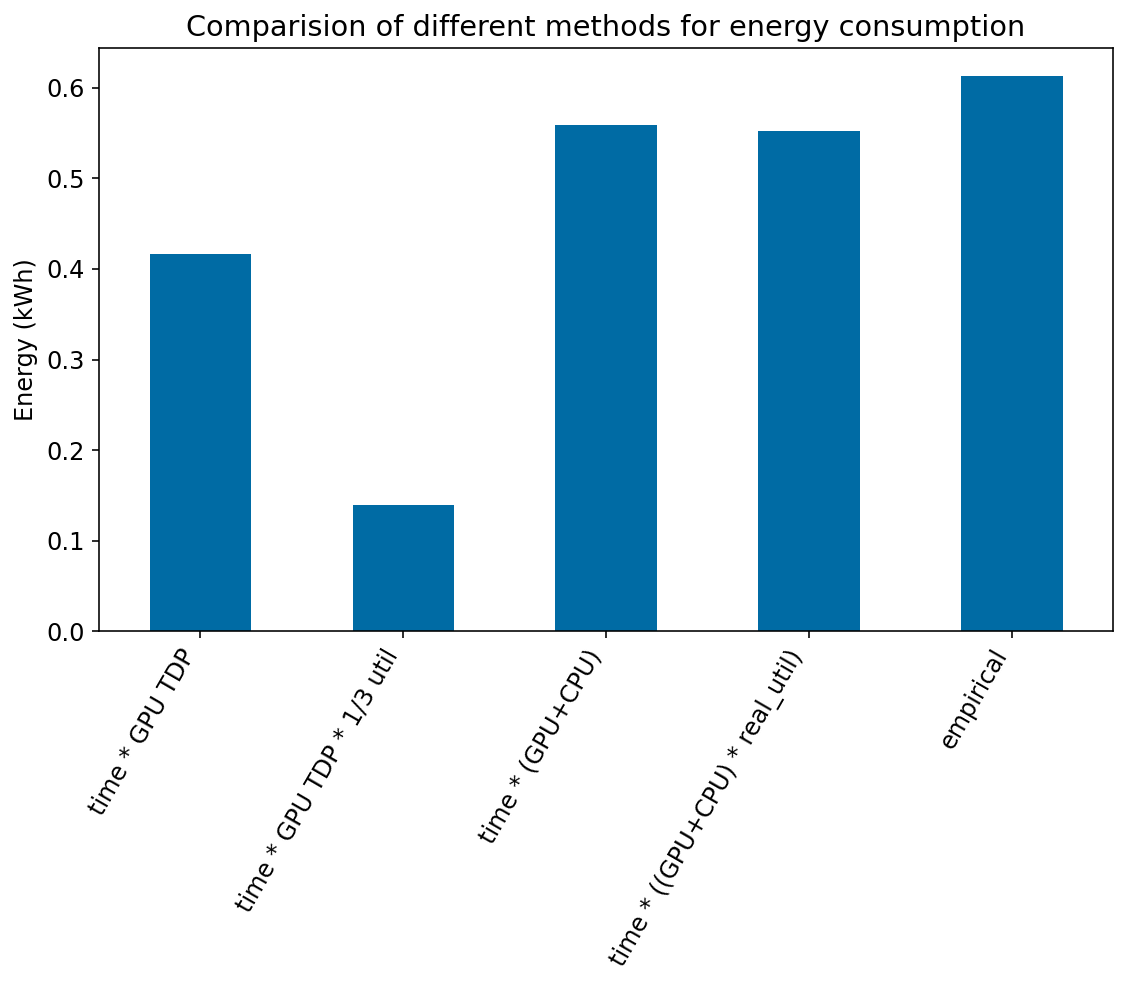

In [131]:
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
df.plot.bar(x='method', y='energy', rot=60,title="Comparision of different methods for energy consumption",
            ax=ax, legend=False)
ax.set_xlabel("")
ax.set_ylabel("Energy (kWh)")
ax.set_xticklabels(df.method, rotation=60, fontdict={'horizontalalignment': 'right','size':12})
plt.tight_layout()
ax.figure.savefig("viz/compareEnergy.png",dpi=300)

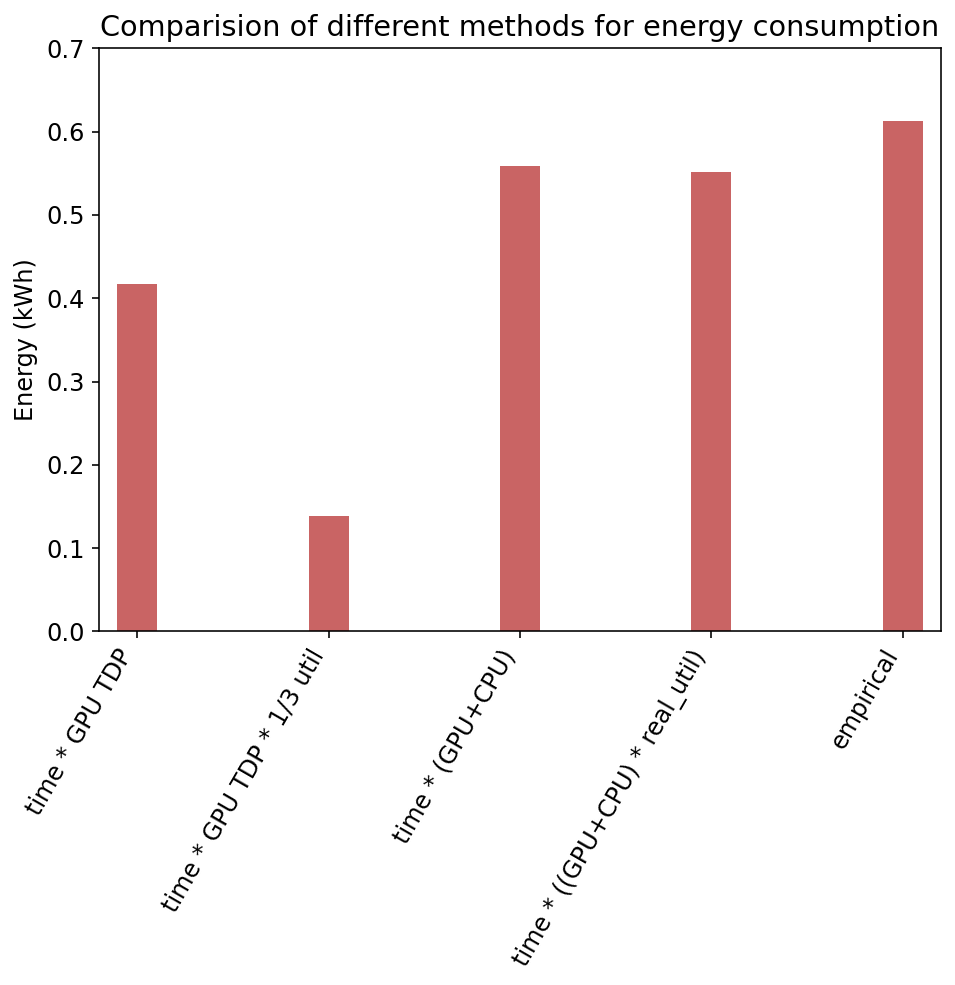

In [132]:
#try other colors
fig, ax = plt.subplots(figsize=(7,7))
ax.vlines(x=df.index, ymin=0, ymax=df.energy, color='firebrick', alpha=0.7, linewidth=20)
# ax.scatter(x=df.index, y=df.energy, s=75, color='firebrick', alpha=0.7)

ax.set_title('Comparision of different methods for energy consumption')
ax.set_ylabel('Energy (kWh)')
ax.set_xticks(df.index)
ax.set_xticklabels(df.method, rotation=60, fontdict={'horizontalalignment': 'right'})
ax.set_ylim(0, 0.7)
plt.tight_layout()
plt.savefig('viz/lollipopCompareplot.png', dpi=300)

In [24]:
percent_lesser =( power_monitor_reading - full_util )/ power_monitor_reading
percent_lesser

0.0880271782215316

## Test correlation

In [25]:
power_monitor_df = pd.read_csv("results/pretrain_power_monitor.csv")

In [26]:
power_monitor_df['last_changed'] = pd.to_datetime(power_monitor_df['last_changed'], errors='coerce')
power_monitor_df.dropna(subset=['last_changed'], inplace=True)
power_monitor_df.set_index('last_changed', inplace=True)

In [27]:
start_date = '2020-06-16'
end_date = '2020-06-16'
start_time = '21:38:59' #one hour behind
end_time = '23:18:51'
subset_df = power_monitor_df.loc[start_date:end_date].between_time(start_time, end_time)[['power_consumption']]
total_energy_pm = ((subset_df['power_consumption']).sum() * 3) / (1000 * 3600) #sampled every 3 sec
total_energy_pm

0.6127022608333333

In [28]:
end = '2020-06-17 00:18:51.137000'
start = '2020-06-16 22:38:59.567000'

start = datetime.strptime(start, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)
end = datetime.strptime(end, "%Y-%m-%d %H:%M:%S.%f") - timedelta(hours=1, minutes=0)   

# start_time = [start for i in range(0,95,5)] 
# end_time = [start + timedelta(hours=0, minutes=i)
#                  for i in range(5,100,5)] 

In [29]:
# try normal distribution
mu, sigma = 50, 20 # mean and standard deviation
s = np.random.normal(mu, sigma, 100)

In [30]:

end_time = [start + timedelta(hours=0, minutes=i)
                 for i in s if i >=0] 
start_time = [start for i in range(len(end_time))] 

In [31]:
# total energy consumed
def energy_consumption(s_date,e_date,s_time,e_time):
    subset_df = power_monitor_df.loc[s_date:e_date].between_time(s_time, e_time)[['power_consumption']]
    return ((subset_df['power_consumption']).sum() * 3) / (1000 * 3600)

In [32]:
df_time_interval= pd.DataFrame(start_time,columns=['start'])

In [33]:
df_time_interval['end'] = end_time
df_time_interval['s_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["start"]]
df_time_interval['e_date'] = [x.date().strftime("%Y-%m-%d") for x in df_time_interval["end"]]
df_time_interval['s_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["start"]]
df_time_interval['e_time'] = [x.time().strftime("%H:%M:%S") for x in df_time_interval["end"]]

In [34]:
for index, row in df_time_interval.iterrows(): 
    df_time_interval.at[index,'empirical'] = energy_consumption(row['s_date'],row['e_date'],
                                            row['s_time'],row['e_time'])

In [35]:
# the model with utilisation 
def model_based(time):
    return (time * ( GPU_TDP * GPU_utilisation/100 +  CPU_TDP * CPU_utilisation) / (1000 * 3600) )

In [36]:
for index, row in df_time_interval.iterrows(): 
    time = row['end'] - row['start']
    seconds = time.total_seconds()
    df_time_interval.at[index,'model_based'] = model_based(seconds)

In [37]:
df_time_interval.tail()

,start,end,s_date,e_date,s_time,e_time,empirical,model_based
95,2020-06-16 21:38:59.567,2020-06-16 22:26:13.936967,2020-06-16,2020-06-16,21:38:59,22:26:13,0.287068,0.260641
96,2020-06-16 21:38:59.567,2020-06-16 22:42:20.258653,2020-06-16,2020-06-16,21:38:59,22:42:20,0.386593,0.349501
97,2020-06-16 21:38:59.567,2020-06-16 23:19:45.802505,2020-06-16,2020-06-16,21:38:59,23:19:45,0.614428,0.555995
98,2020-06-16 21:38:59.567,2020-06-16 22:56:11.302471,2020-06-16,2020-06-16,21:38:59,22:56:11,0.472110,0.425921
99,2020-06-16 21:38:59.567,2020-06-16 22:24:36.880451,2020-06-16,2020-06-16,21:38:59,22:24:36,0.277161,0.251716


coeff: 0.999988081276219
r2: 0.9999761626944939


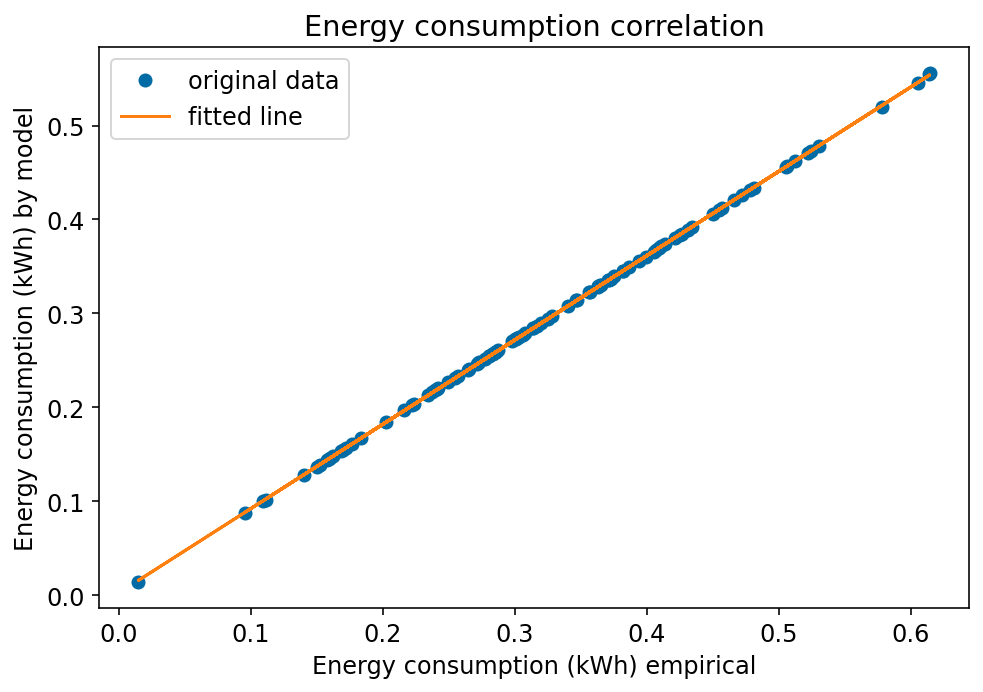

In [38]:
x = df_time_interval['empirical']
y = df_time_interval['model_based']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption (kWh) empirical")
plt.ylabel("Energy consumption (kWh) by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/pretrain_model_vs_empirical.png',dpi=300)

In [39]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.03344048180880499 
 mae: 0.030954870788403106


## See how the values scale with time using finetuning training 

In [51]:
df_finetune = pd.read_csv("results/model_pm_energy_finetune.csv")

In [52]:
df_finetune.columns

Index(['dataset', 'batchsize', 'max_seq_len', 'mean_power', 'total_time',
       'power', 'summed_power', 'gpu_util', 'gpu1_util', 'gpu2_util',
       'gpu1_mean_power', 'gpu2_mean_power', 'memory_util', 'memory_used',
       'start_time', 'end_time', 'total_energy', 'cpu_time', 'dataset_size',
       'total_batchsize', 'samples_per_sec', 'time_per_sample', 'TFLOPs',
       'PFLOPs', 'PFLOPs_per_example', 'start_seconds', 'end_seconds',
       's_date', 'e_date', 's_time', 'e_time', 'pm_mean_power', 'pm_power',
       'pm_energy_consumption', 'CO2e', 'kg CO2e/kWh', 'time_in_hour'],
      dtype='object')

In [53]:
df_finetune['power'].count()

51

In [54]:
df_finetune['time * GPU TDP'] = df_finetune['total_time']/3600 *( GPU_TDP * 2) / 1000
df_finetune['time * (GPU + CPU)'] =((df_finetune['total_time']/3600 * GPU_TDP *2) + (df_finetune['cpu_time']/3600 * CPU_TDP)) / 1000
df_finetune['time * (GPU + CPU) * real_util'] = ((df_finetune['total_time']/3600 *  GPU_TDP * 2* df_finetune['gpu_util']/100 )
  + (df_finetune['cpu_time']/3600 * CPU_TDP * CPU_utilisation)) / 1000

In [55]:
df_64 = df_finetune.loc[(df_finetune.batchsize == 64) & (df_finetune.max_seq_len == 128)]
df_64 = df_64.sort_values('dataset_size')
features = ['dataset','gpu_util','time * GPU TDP','time * (GPU + CPU)','time * (GPU + CPU) * real_util', 'pm_energy_consumption']
df_64[features]

,dataset,gpu_util,time * GPU TDP,time * (GPU + CPU),time * (GPU + CPU) * real_util,pm_energy_consumption
1,WNLI,86.753205,0.001822,0.002275,0.002033,0.001955
2,RTE,90.220930,0.006041,0.007210,0.006620,0.007000
7,MRPC,93.104839,0.008735,0.010363,0.009760,0.009915
15,STS-B,95.063168,0.014237,0.016823,0.016121,0.016306
19,CoLA,92.684397,0.019933,0.023488,0.022030,0.022874
29,SST-2,93.989130,0.157824,0.184844,0.175358,0.181335
36,QNLI,94.669243,0.246555,0.288684,0.275540,0.287262
48,QQP,93.259980,0.416589,0.487409,0.459331,0.453297
47,QQP,93.643194,0.166705,0.195045,0.184448,0.186924
46,QQP,93.229384,0.499961,0.584954,0.551104,0.538160


In [56]:
features = ['dataset','time * GPU TDP','time * (GPU + CPU)',
            'time * (GPU + CPU) * real_util','pm_energy_consumption','kg CO2e/kWh']
bert_finetune = df_64[features]
bert_finetune.to_csv("results/bert_finetune_appendix.csv", index=False)

In [57]:
df_plot = df_64[df_64['dataset'].isin(['MRPC','CoLA','SST-2','MNLI'])]

In [58]:
features = ['dataset','time * GPU TDP','time * (GPU + CPU)','time * (GPU + CPU) * real_util', 'pm_energy_consumption']
df_plot = df_plot[features]
df_plot.rename(columns={'pm_energy_consumption':'empirical', 'dataset':'model'},
                   inplace=True)
df_plot.set_index('model', inplace=True)

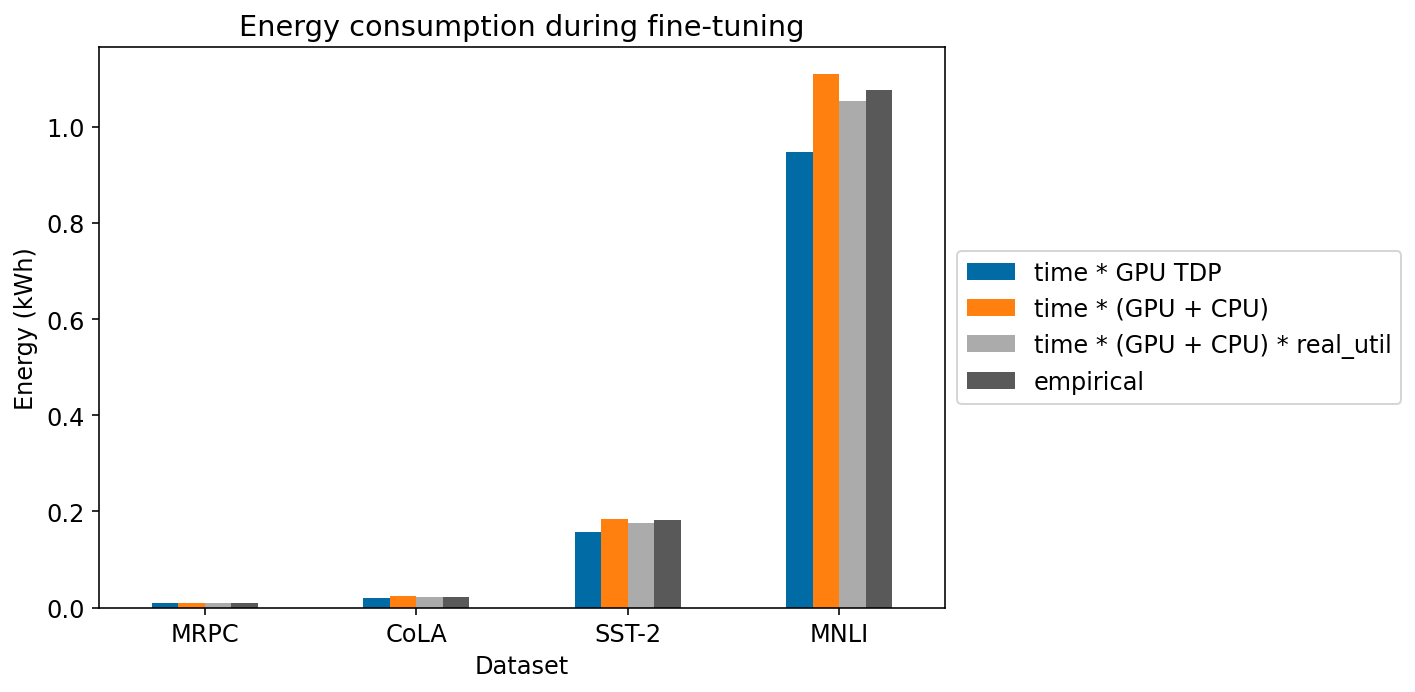

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
df_plot.plot.bar(rot=0, ax=ax).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));
ax.set_ylabel("Energy (kWh)")
ax.set_xlabel("Dataset")
ax.set_title("Energy consumption during fine-tuning")
plt.tight_layout()
ax.figure.savefig("viz/finetuneCompareEnergy.png",dpi=300)

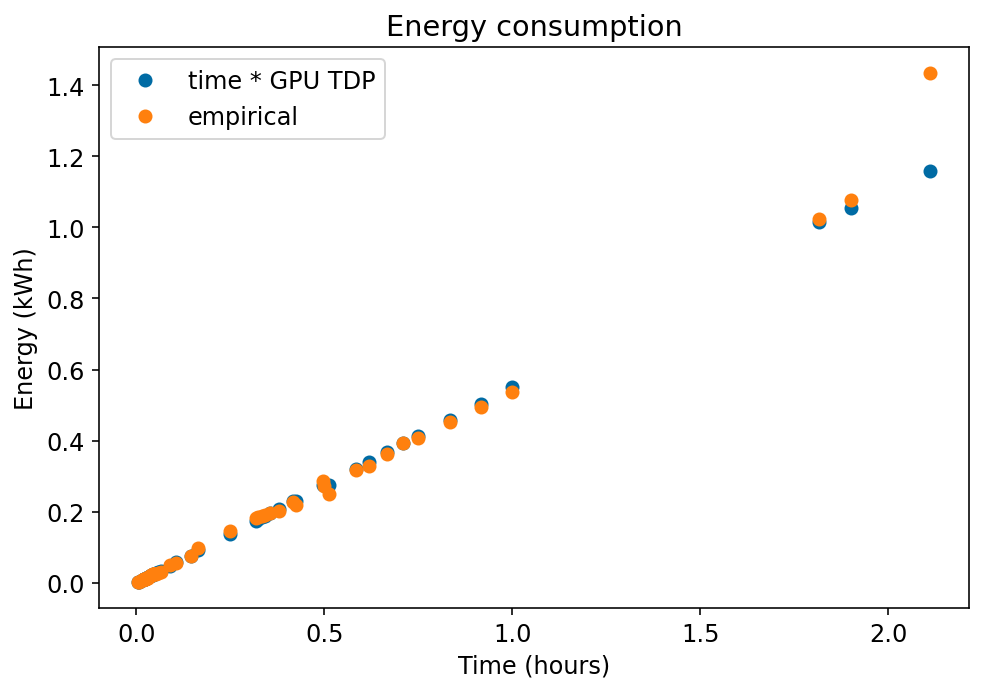

In [60]:
x = df_finetune['time_in_hour']
y1 = df_finetune['time * (GPU + CPU) * real_util']
y2 = df_finetune['pm_energy_consumption']
plt.figure(figsize=(7,5))
plt.plot(x, y1,'o', label="time * GPU TDP")
plt.plot(x, y2,'o', label="empirical")
plt.xlabel("Time (hours)")
plt.ylabel("Energy (kWh)")
plt.title("Energy consumption")
plt.legend()
plt.tight_layout()
plt.savefig('viz/mlco2ModelVsPMPower.png',dpi=300)

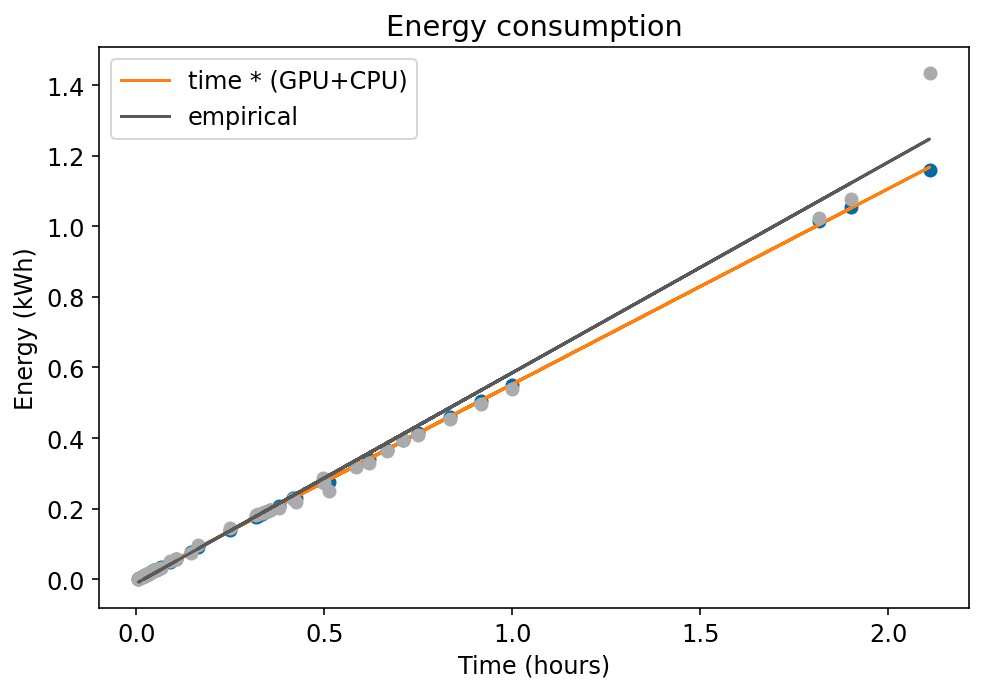

In [61]:
x = df_finetune['time_in_hour']
y1 = df_finetune['time * (GPU + CPU) * real_util']
y2 = df_finetune['pm_energy_consumption']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y1)
plt.plot(x, y1,'o')
plt.plot(x, slope * x + intercept, label='time * (GPU+CPU)')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y2)
plt.plot(x, y2,'o')
plt.plot(x, slope * x + intercept, label='empirical')
plt.xlabel("Time (hours)")
plt.ylabel("Energy (kWh)")
plt.title("Energy consumption")
plt.legend()
plt.tight_layout()
plt.savefig('viz/CPU_GPU_ModelVsPMPower.png',dpi=300)

In [62]:
stat, p = stats.normaltest(x)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=35.997, p=0.000
Sample does not look Gaussian (reject H0)


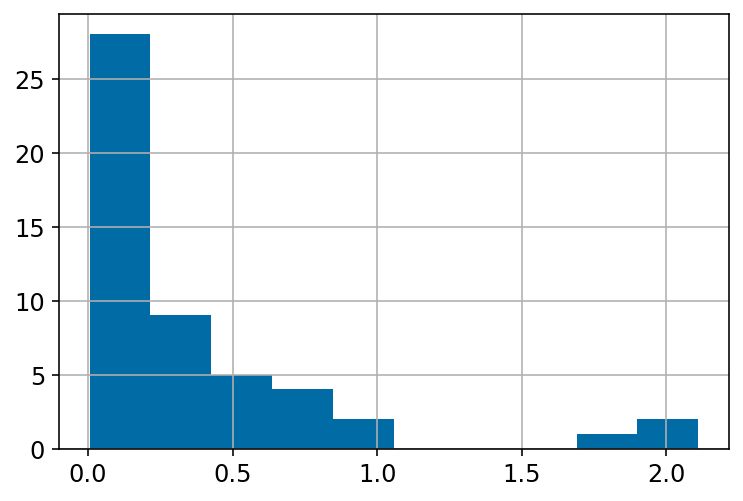

In [63]:
x.hist()

In [64]:
df_64 = df_finetune.loc[(df_finetune.batchsize == 64) & (df_finetune.max_seq_len == 128)]
df_64 = df_64.sort_values('dataset_size')

coeff: 0.9935292099543968
r2: 0.9871002910326078


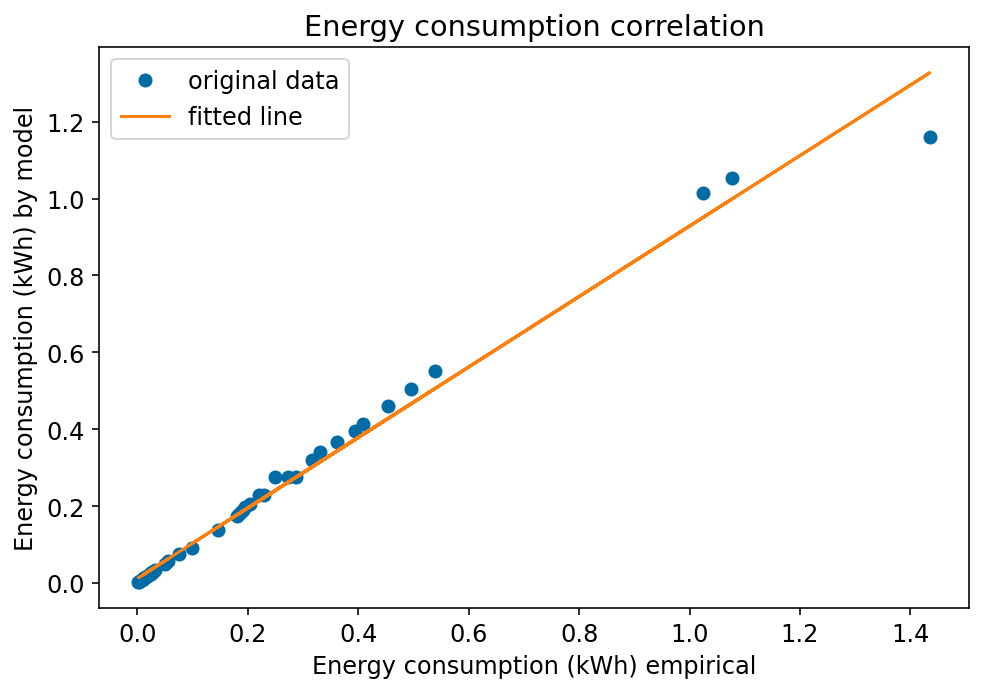

In [65]:
x = df_finetune['pm_energy_consumption']
y = df_finetune['time * (GPU + CPU) * real_util']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.ylabel("Energy consumption (kWh) by model")
plt.xlabel("Energy consumption (kWh) empirical")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/Corr_CPU_GPU_ModelVsPMPower.png',dpi=300)

In [66]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.03906616847293375 
 mae: 0.009145447468261169


coeff: 0.9995576263537411
r2: 0.9991154484019251


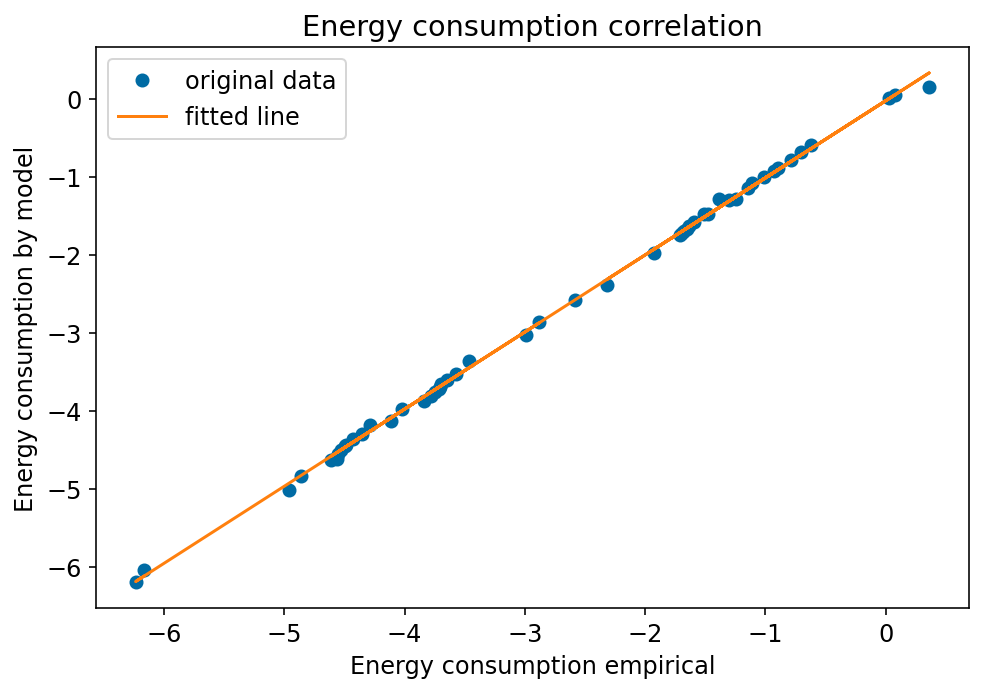

In [67]:
## try log

x = np.log(df_finetune['pm_energy_consumption'])
y = np.log(df_finetune['time * (GPU + CPU) * real_util'])
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.ylabel("Energy consumption by model")
plt.xlabel("Energy consumption empirical")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/log_Corr_CPU_GPU_ModelVsPMPower.png',dpi=300)

## merge data 

In [68]:
df_finetune.rename(columns={'pm_energy_consumption':'empirical','time * (GPU + CPU) * real_util':'model_based'},
                   inplace=True)

In [69]:
merge_df = df_finetune.append(df_time_interval)

coeff: 0.9947996838561077
r2: 0.9896264110002119


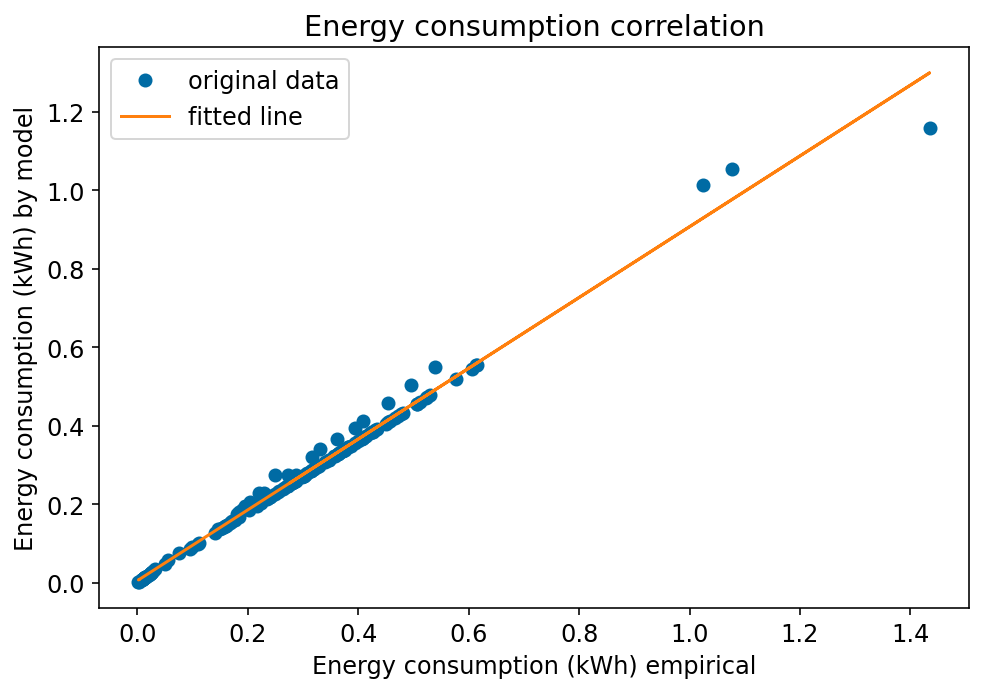

In [70]:
x = merge_df['empirical']
y = merge_df['model_based']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption (kWh) empirical")
plt.ylabel("Energy consumption (kWh) by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/model_vs_empirical.png',dpi=300)

In [71]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.03544055968021131 
 mae: 0.02358877417034192


coeff: 0.9993556498523936
r2: 0.9987117148918998


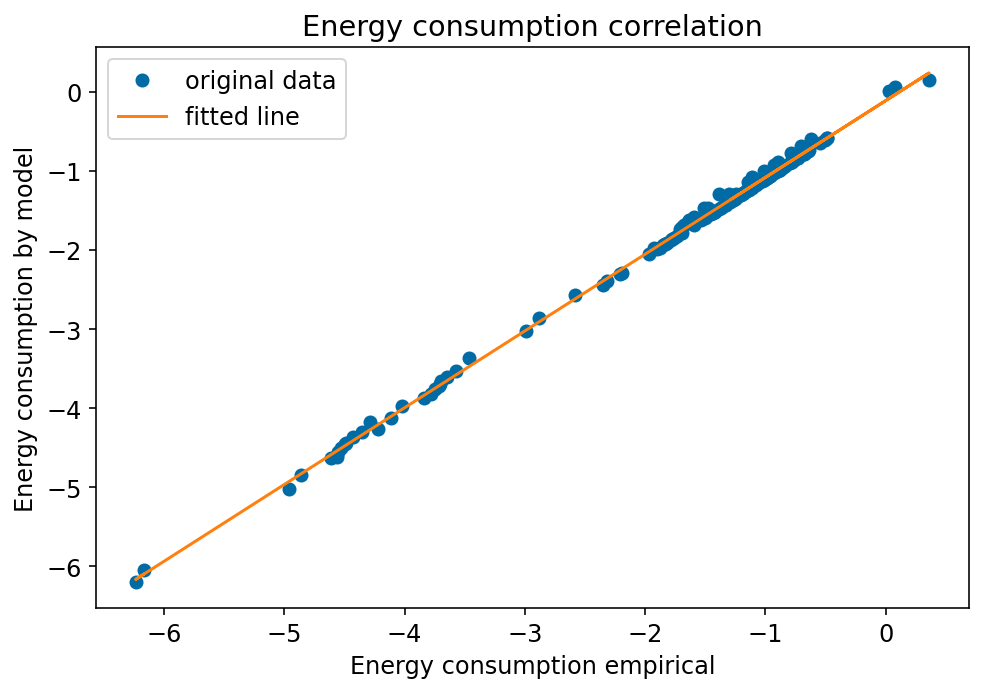

In [72]:
#log 
x = np.log(merge_df['empirical'])
y = np.log(merge_df['model_based'])
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption empirical")
plt.ylabel("Energy consumption by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/log_model_vs_empirical.png',dpi=300)

In [73]:
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")

rmse: 0.08515463832101558 
 mae: 0.07706607166447504


## Merge inference data

In [74]:
infer = pd.read_csv("results/inferenceProcessedData.csv",)
infer

,model,time * GPU TDP,time * (GPU + CPU),time * (GPU + CPU) * real_util,empirical
0,STS-B,0.024742,0.033178,0.019618,0.023768
1,CoLA,0.024321,0.032590,0.018521,0.021950
2,MRPC,0.024812,0.033273,0.019646,0.023455


In [75]:
infer.rename(columns={'time * (GPU + CPU) * real_util':'model_based'},
                   inplace=True)

In [76]:
new_df = merge_df.append(infer)

coeff: 0.9949518297174571
r2: 0.9899291434581158
p-value:  1.1105045889525012e-153
rmse: 0.035097684478300695 
 mae: 0.023203197292170727
mse:  0.0012318474557383495


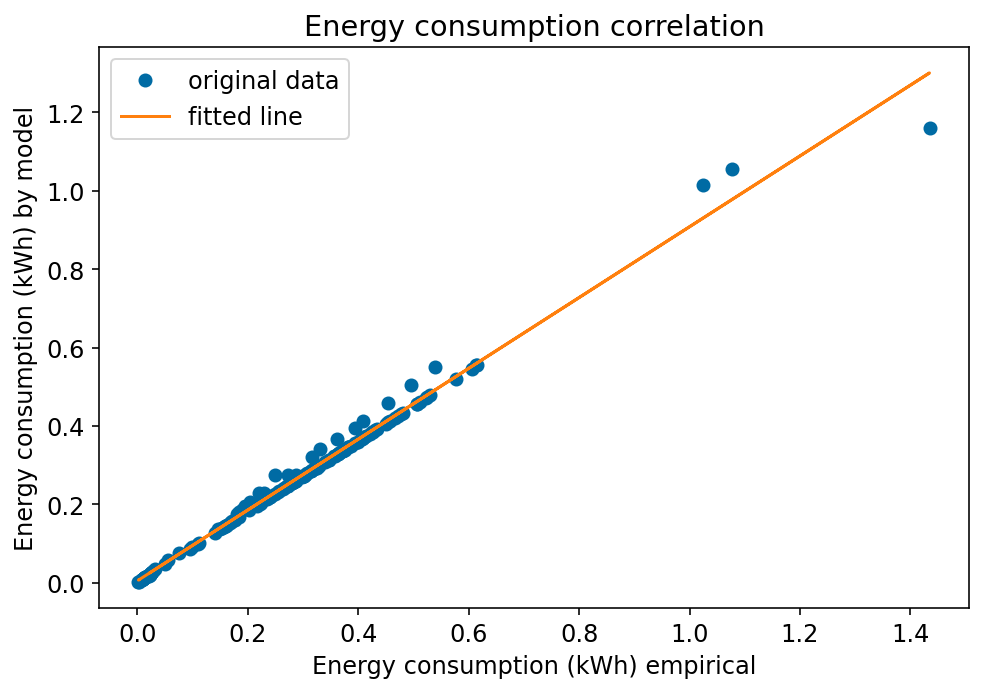

In [88]:
x = new_df['empirical']
y = new_df['model_based']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
print("p-value: ", p_value)
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption (kWh) empirical")
plt.ylabel("Energy consumption (kWh) by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/model_vs_empiricalAll.png',dpi=300)
mse = metrics.mean_squared_error(x,y)
rmse = mse ** (1/2)
mae = metrics.mean_absolute_error(x, y)
print(f"rmse: {rmse} \n mae: {mae}")
print("mse: ",mse)

coeff: 0.9992082067183317
r2: 0.9984170403732642


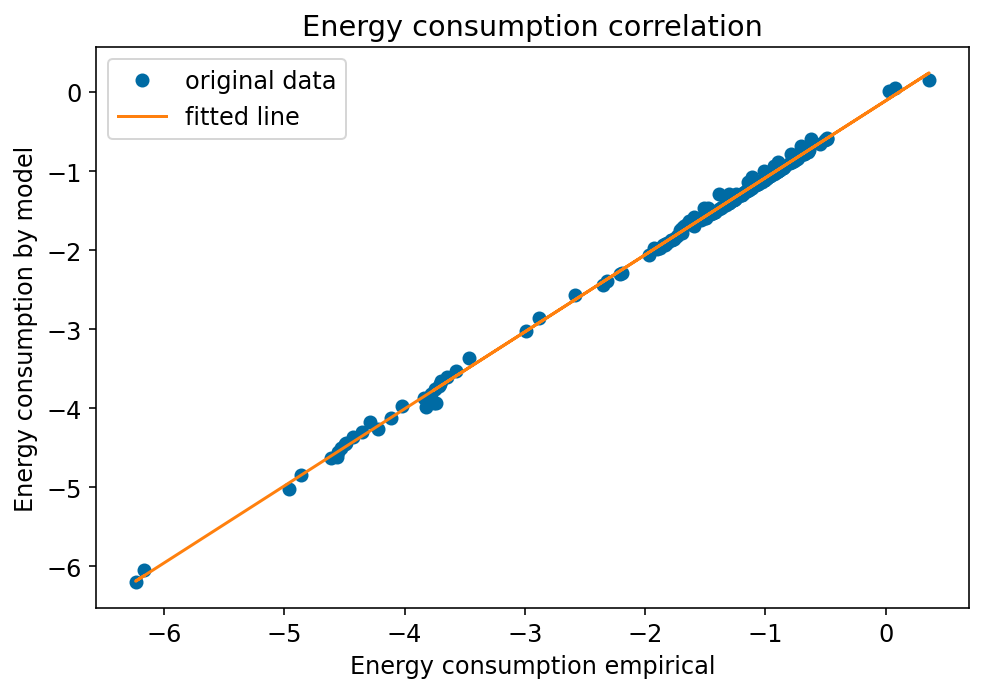

In [78]:
#log 
x = np.log(new_df['empirical'])
y = np.log(new_df['model_based'])
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(f"coeff: {r_value}")
print(f"r2: {r_value ** 2}")
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption empirical")
plt.ylabel("Energy consumption by model")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/log_model_vs_empiricalAll.png',dpi=300)

## Ridge regression

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge = Ridge()
x = new_df['empirical'].values.reshape(-1, 1)
y = new_df['model_based'].values

parameters = {"alpha":[1e-20,1e-15,1e-10,1e-7,1e-4,1e-3,1e-2,1,5,10,20]}

ridge_regressor = GridSearchCV(ridge,parameters,scoring="neg_mean_squared_error",cv=5)
ridge_regressor.fit(x,y)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-20, 1e-15, 1e-10, 1e-07, 0.0001, 0.001,
                                   0.01, 1, 5, 10, 20]},
             scoring='neg_mean_squared_error')

In [97]:
print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)
print(ridge_regressor.score(x,y))

{'alpha': 1e-20}
-0.00038156822701730815
-0.0003524776304831324


In [118]:
df_co2 = pd.read_csv("results/co2data.csv")
uk_co2 = df_co2.loc[df_co2.country == 'United Kingdom'].impact.mean()

Bert base trained on 64 V100 for 79 hours (from nlp paper)

In [110]:
V100TDP = 300 # watt
numGPU = 64
time = 79 # hour
util = 0.63 # assumption from related work
pue = 1.58 #from related work
energy = pue * time * V100TDP * numGPU * util /1000
print(f"{energy} kWh")

1509.82272 kWh


Bert base on 16 TPU for 4 days (96 hours)

In [138]:
TPUv2 = 250
numTPU = 16
time = 96
util = 0.9
pue = 1.58
energy_base = pue * time * TPUv2 * numTPU * util /1000
co2 = energy_base * uk_co2 /1000
print(f"{energy_base} kWh")
print(f"co2 : {co2}")

546.048 kWh
co2 : 340.187904


bert large on 64 TPU for 4 days

In [137]:
TPUv2 = 250
numTPU = 64
time = 96
util = 0.9
pue = 1.58
energy_large = pue * time * TPUv2 * numTPU * util /1000
co2 = energy_large * uk_co2 /1000
print(f"{energy_large} kWh")
print(f"co2 : {co2}")

2184.192 kWh
co2 : 1360.751616


In [134]:
df_plot = df_co2.sort_values('impact')
df = df_plot[['country','impact']].groupby('country').mean()
df.sort_values('impact', inplace=True)
df.reset_index(inplace=True)

In [139]:
df['bert_large'] = energy_large * df['impact'] / 1000
df['bert_base'] = energy_base * df['impact']/1000

In [140]:
df

,country,impact,bert_large,bert_base
0,Switzerland,16.000000,34.947072,8.736768
1,Canada,32.325000,70.604006,17.651002
2,Sweden,47.000000,102.657024,25.664256
3,France,105.000000,229.340160,57.335040
4,Brazil,205.000000,447.759360,111.939840
5,Finland,211.000000,460.864512,115.216128
6,Belgium,267.000000,583.179264,145.794816
7,USA,395.615789,864.100842,216.025211
8,Singapore,419.000000,915.176448,228.794112
9,Japan,516.000000,1127.043072,281.760768


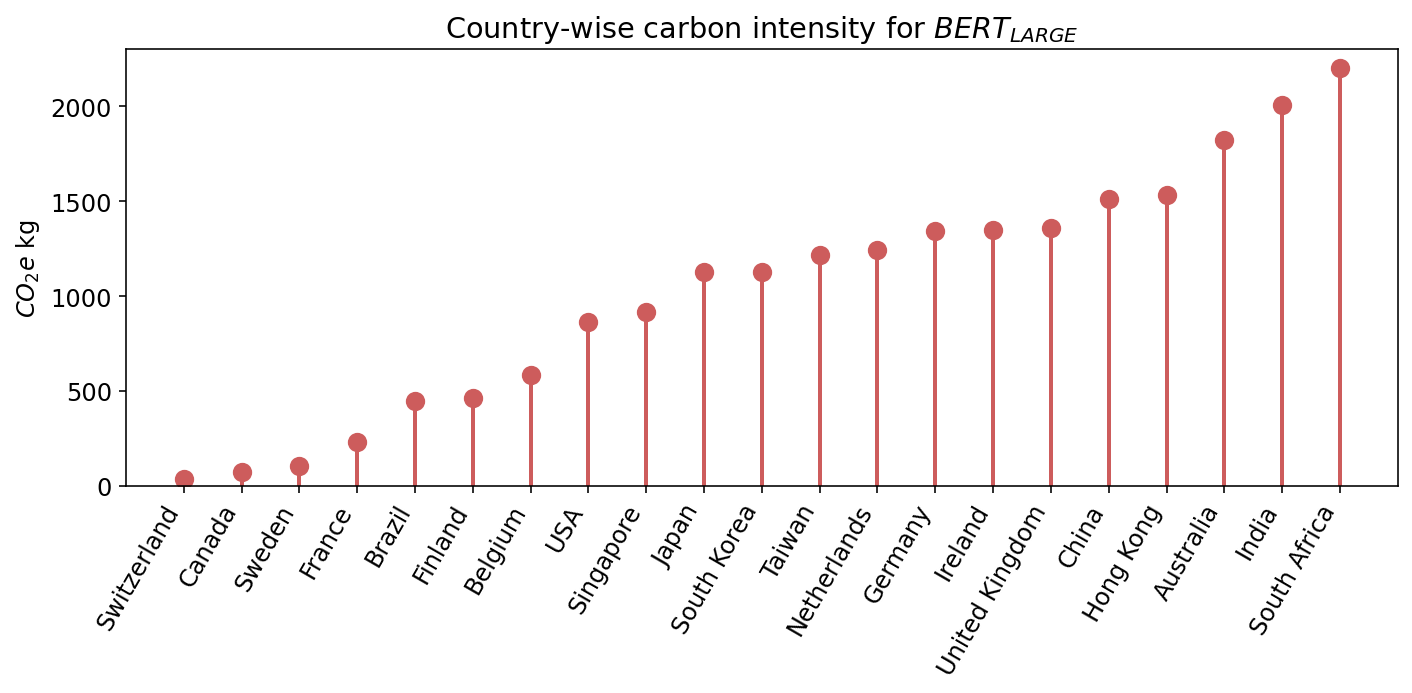

In [158]:
fig, ax = plt.subplots(figsize=(10,5))
ax.vlines(x=df.index, ymin=0, ymax=df.bert_large, color='indianred',  linewidth=2)
ax.scatter(x=df.index, y=df.bert_large, s=75, color='indianred')

ax.set_title('Country-wise carbon intensity for $BERT_{LARGE}$')
ax.set_ylabel('$CO_2e$ kg')
ax.set_xticks(df.index)
ax.set_xticklabels(df.country, rotation=60, fontdict={'horizontalalignment': 'right', 'size':12})
ax.set_ylim(0, 2300)
plt.tight_layout()
plt.savefig('viz/bertlarge_countrywiseco2.png', dpi=300)